In [41]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

#Load data for both Traffic and Air (PRE+POST)
Air_pre = pd.read_csv('/Users/jes/Library/CloudStorage/OneDrive-RobertGordonUniversity(2)/ProjectMINE/Birmingham/Air_Pre_Final.csv', parse_dates=['Datetime'])
Air_post = pd.read_csv('/Users/jes/Library/CloudStorage/OneDrive-RobertGordonUniversity(2)/ProjectMINE/Birmingham/Air_Post_Final.csv', parse_dates=['Datetime'])

Traffic_pre = pd.read_csv('/Users/jes/Library/CloudStorage/OneDrive-RobertGordonUniversity(2)/ProjectMINE/Birmingham/Traffic_Pre.csv', parse_dates=['datetime'])
Traffic_post = pd.read_csv('/Users/jes/Library/CloudStorage/OneDrive-RobertGordonUniversity(2)/ProjectMINE/Birmingham/Traffic_Post.csv', parse_dates=['datetime'])

for df in [Air_pre, Air_post, Traffic_pre, Traffic_post]:
    df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
    df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
    df
    

In [42]:
# covert to GeoDataFrames
geo_air_pre = gpd.GeoDataFrame(
    Air_pre, 
    geometry=gpd.points_from_xy(Air_pre.longitude, Air_pre.latitude), 
    crs='epsg:4326')
geo_air_post = gpd.GeoDataFrame(
    Air_post, 
    geometry=gpd.points_from_xy(Air_post.longitude, Air_post.latitude), 
    crs='epsg:4326')
geo_traffic_pre = gpd.GeoDataFrame(
    Traffic_pre, 
    geometry=gpd.points_from_xy(Traffic_pre.longitude, Traffic_pre.latitude), 
    crs='epsg:4326')
geo_traffic_post = gpd.GeoDataFrame(
    Traffic_post, 
    geometry=gpd.points_from_xy(Traffic_post.longitude, Traffic_post.latitude), 
    crs='epsg:4326')

In [43]:
import geopandas as gpd

for gdf in [geo_air_pre, geo_air_post, geo_traffic_pre, geo_traffic_post]:
    assert gdf.crs is not None, "CRS missing"
    print(gdf.columns.tolist(), gdf.crs)


['Datetime', 'site_name', 'NO2', 'Period', 'latitude', 'longitude', 'geometry'] epsg:4326
['Datetime', 'site_name', 'NO2', 'Period', 'latitude', 'longitude', 'geometry'] epsg:4326
['count_point_id', 'direction_of_travel', 'year', 'count_date', 'hour', 'region_id', 'region_name', 'local_authority_id', 'local_authority_name', 'road_name', 'road_type', 'start_junction_road_name', 'end_junction_road_name', 'easting', 'northing', 'latitude', 'longitude', 'link_length_km', 'link_length_miles', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles', 'datetime', 'geometry'] epsg:4326
['count_point_id', 'direction_of_travel', 'year', 'count_date', 'hour', 'region_id', 'region_name', 'local_authority_id', 'local_authority_name', 'road_name', 'road_type', 'start_junction_road_name', 'end_junction_road_name', 'easting', 'northing', 'latitude', 'longitude', 'link_length_km', 'link_length_miles', 'pedal_cycles', 'two_wheeled_moto

In [44]:
geo_air_pre_27700     = geo_air_pre.to_crs(27700)
geo_air_post_27700    = geo_air_post.to_crs(27700)
geo_traffic_pre_27700 = geo_traffic_pre.to_crs(27700)
geo_traffic_post_27700= geo_traffic_post.to_crs(27700)


In [45]:
out_gpkg = "/Users/jes/Library/CloudStorage/OneDrive-RobertGordonUniversity(2)/ProjectMINE/Birmingham/CAZ_pipeline.gpkg"

# Save WGS84 (lat/lon) layers
geo_air_pre.to_file(out_gpkg, layer="air_pre_wgs84", driver="GPKG")
geo_air_post.to_file(out_gpkg, layer="air_post_wgs84", driver="GPKG")
geo_traffic_pre.to_file(out_gpkg, layer="traffic_pre_wgs84", driver="GPKG")
geo_traffic_post.to_file(out_gpkg, layer="traffic_post_wgs84", driver="GPKG")

# Save BNG (meters) layers for analysis
geo_air_pre_27700.to_file(out_gpkg, layer="air_pre_bng", driver="GPKG")
geo_air_post_27700.to_file(out_gpkg, layer="air_post_bng", driver="GPKG")
geo_traffic_pre_27700.to_file(out_gpkg, layer="traffic_pre_bng", driver="GPKG")
geo_traffic_post_27700.to_file(out_gpkg, layer="traffic_post_bng", driver="GPKG")


In [46]:
#spatiial join ; match each air site to the nearest traffic sensor
air_traffic_pre = gpd.sjoin_nearest(geo_air_pre, geo_traffic_pre, how='left', distance_col='distance_meters')
air_traffic_post = gpd.sjoin_nearest(geo_air_post, geo_traffic_post, how='left', distance_col='distance_meters') 
print('average match distance (m)')
print('pre:', air_traffic_pre['distance_meters'].mean(), 'post:', air_traffic_post['distance_meters'].mean())

/Users/jes/Project-Work/.venv/lib/python3.12/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/jes/Project-Work/.venv/lib/python3.12/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


average match distance (m)
pre: 0.013226446509444484 post: 0.012263872058031328


In [47]:
air_traffic_pre=air_traffic_pre[air_traffic_pre['distance_meters']<1000]
air_traffic_post=air_traffic_post[air_traffic_post['distance_meters']<1000]

In [48]:
# --- Round all datetime fields to the nearest hour ---
air_traffic_pre['datetime_hour']  = air_traffic_pre['Datetime'].dt.floor('h')
air_traffic_post['datetime_hour'] = air_traffic_post['Datetime'].dt.floor('h')
Traffic_pre['datetime_hour']      = pd.to_datetime(Traffic_pre['datetime']).dt.floor('h')
Traffic_post['datetime_hour']     = pd.to_datetime(Traffic_post['datetime']).dt.floor('h')

# --- Merge by datetime_hour (hourly match) ---
merged_pre  = pd.merge(
    air_traffic_pre, Traffic_pre,
    on='datetime_hour', how='inner',
    suffixes=('_air', '_traf')
)

merged_post = pd.merge(
    air_traffic_post, Traffic_post,
    on='datetime_hour', how='inner',
    suffixes=('_air', '_traf')
)


In [49]:
# Example correlation: NO2 vs all_motor_vehicles
corr_pre  = merged_pre[['NO2','all_motor_vehicles_traf']].dropna()
corr_post = merged_post[['NO2','all_motor_vehicles_traf']].dropna()

r_pre,  p_pre  = pearsonr(corr_pre['NO2'],  corr_pre['all_motor_vehicles_traf'])
r_post, p_post = pearsonr(corr_post['NO2'], corr_post['all_motor_vehicles_traf'])

print(f"Pre-CAZ correlation (NO₂ vs traffic): r={r_pre:.3f}, p={p_pre:.3e}")
print(f"Post-CAZ correlation (NO₂ vs traffic): r={r_post:.3f}, p={p_post:.3e}")


Pre-CAZ correlation (NO₂ vs traffic): r=-0.028, p=1.662e-12
Post-CAZ correlation (NO₂ vs traffic): r=0.033, p=9.197e-18


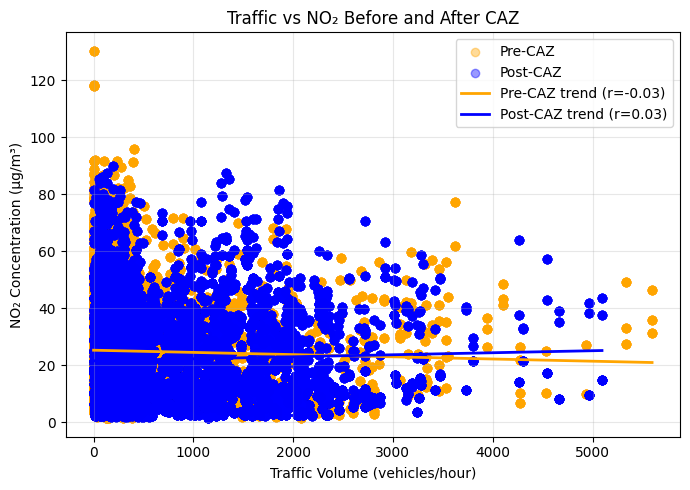

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

plt.figure(figsize=(7,5))

# Scatter points with transparency
plt.scatter(corr_pre['all_motor_vehicles_traf'], corr_pre['NO2'],
            alpha=0.4, color='orange', label='Pre-CAZ')
plt.scatter(corr_post['all_motor_vehicles_traf'], corr_post['NO2'],
            alpha=0.4, color='blue', label='Post-CAZ')

# Fit trendlines
for data, color, label in [(corr_pre, 'orange', 'Pre-CAZ'), (corr_post, 'blue', 'Post-CAZ')]:
    slope, intercept, r, p, _ = linregress(data['all_motor_vehicles_traf'], data['NO2'])
    x_vals = np.linspace(0, data['all_motor_vehicles_traf'].max(), 100)
    plt.plot(x_vals, slope*x_vals + intercept, color=color, linewidth=2,
             label=f'{label} trend (r={r:.2f})')

plt.xlabel('Traffic Volume (vehicles/hour)')
plt.ylabel('NO₂ Concentration (µg/m³)')
plt.title('Traffic vs NO₂ Before and After CAZ')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


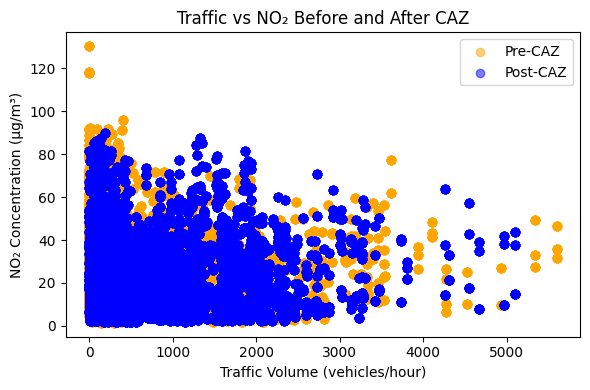

In [52]:
plt.figure(figsize=(6,4))
plt.scatter(corr_pre['all_motor_vehicles_traf'], corr_pre['NO2'], alpha=0.5, label='Pre-CAZ', color='orange')
plt.scatter(corr_post['all_motor_vehicles_traf'], corr_post['NO2'], alpha=0.5, label='Post-CAZ', color='blue')
plt.xlabel('Traffic Volume (vehicles/hour)')
plt.ylabel('NO₂ Concentration (µg/m³)')
plt.title('Traffic vs NO₂ Before and After CAZ')
plt.legend()
plt.tight_layout()
plt.show()
